#A Comparative Study of Preconditioner Update Strategies in the SOAP Optimizer


This is the notebook containing the code used in the first part of the project, namely for the training of the ResNet18 architecture with Dropout and Stochastic Depth on the task of classifying images from the CIFAR-10 dataset, and the experiments and plots run on it.

First of all, let's import all the necessary Python modules:

In [1]:
import torch
from torchvision import transforms
import torchvision.datasets
from torch.optim.optimizer import Optimizer
import matplotlib.pyplot as plt
import numpy as np

import timm

import tqdm
import time

In the following cell, we have defined different schedules for the update frequency of the preconditioner:

In [2]:
counter = 0 # Keeps track of how many times we update the preconditioner

# The frequency stays the same throughout all the iterations of the training process
def constant_frequency(state):
    """
    Function signature will be described only here, as it is the same throughout all the frequency schedules.

    Parameters:
        state: dictionary containing the information used by the SOAP algorithm.
          When calling a schedule, SOAP passes the state dictionary as an argument.

    Returns:
      True when the frequency must be updated in the current iteration based on the received state, False otherwise.
    """

    global counter
    if "last_update" not in state:
        state["last_update"] = 0
        counter = 0

    if state['step'] % state['precondition_frequency'] == 0:
        counter += 1
        return True
    else:
        return False

# The frequency gets halved down at each update of the preconditioner, making the updates more and more sparse as the training progresses
def halving_frequency(state):
    global counter
    if "last_update" not in state:
        state["last_update"] = 0
        counter = 1
        return True

    if state['step'] - state['last_update'] >= state['precondition_frequency']:
        state['last_update'] = state['step']
        state['precondition_frequency'] = max(1, state['precondition_frequency']//2) # Clip the frequency to min 1
        counter += 1
        return True
    else:
        return False

# The frequency gets doubled at each update of the preconditioner, making the updates more and more frequent as the training progresses
def doubling_frequency(state):
    global counter
    if "last_update" not in state:
        state["last_update"] = 0
        counter = 1
        return True

    if state['step'] - state['last_update'] >= state['precondition_frequency']:
        state['last_update'] = state['step']
        state['precondition_frequency'] = min(1024, state['precondition_frequency']*2)  # Clip the frequency to max 1024
        counter += 1
        return True
    else:
        return False

# Same as the previous, but with a tighter clip as the maximum frequency
def doubling_frequency_clipped(state):
    global counter
    if "last_update" not in state:
        state["last_update"] = 0
        counter = 1
        return True

    if state['step'] - state['last_update'] >= state['precondition_frequency']:
        state['last_update'] = state['step']
        state['precondition_frequency'] = min(256, state['precondition_frequency']*2)  # Clip the frequency to max 1024
        counter += 1
        return True
    else:
        return False

# The frequency gets doubled at each update of the preconditioner up to a certain threshold,
# and then gets halved down to 1 once again, leading to a lot of updates at both start and end of training but not in the middle
def doubling_then_halving_frequency(state):
    global counter
    if "last_update" not in state:
        state['last_update'] = 0
        state['last_freq'] = 1
        state['halving'] = False
        counter = 1
        return True

    if state['last_freq'] >= state['precondition_frequency']:
        state['halving'] = True

    if state['step'] - state['last_update'] >= state['last_freq']:
        state['last_update'] = state['step']
        if state['halving']:
            state['last_freq'] = max(1, state['last_freq']//2)
            counter += 1
        else:
            state['last_freq'] = min(1024, state['last_freq']*2)
            counter += 1
        return True
    else:
        return False

# A fixed interval of 256 iterations is defined, and the frequency gets doubled at the end of each interval
def fixed_interval_doubling_frequency(state):
    global counter
    if "last_update" not in state:
        state['last_update'] = 0
        counter = 1
        return True

    if state['step'] - state['last_update'] >= 256:
        state['last_update'] = state['step']
        state['precondition_frequency'] = min(256, state['precondition_frequency']*2)

    if (state['step'] - state['last_update']) % state['precondition_frequency'] == 0:
        counter += 1
        return True
    else:
        return False

# There is not a real "frequency", but the preconditioner gets updated when the loss changes more than a certain threshold
def loss_dependent_frequency(state):
    global counter
    if "last_loss" not in state:
        state['last_loss'] = state['loss']
        counter = 1
        return True

    if abs(state['last_loss'] - state['loss']) >= state['precondition_frequency']:
        state['last_loss'] = state['loss']
        counter += 1
        return True
    else:
        return False

Here's the state-of-the-art implementation of the SOAP optimizer, directly from the GitHub repository of one of the paper co-authors, Nikhil Vyas (https://github.com/nikhilvyas/SOAP/blob/main/soap.py).

We have highlighted our own changes to the code with the comment *# Our addition*:

In [3]:
# Courtesy of https://github.com/nikhilvyas/SOAP/blob/main/soap.py, one of the co-authors of the original SOAP paper

import torch
import torch.nn as nn
import torch.optim as optim

from itertools import chain

from typing import Callable            # Our addition

# Parts of the code are modifications of Pytorch's AdamW optimizer
# Parts of the code are modifications of code from https://github.com/jiaweizzhao/GaLore/blob/master/galore_torch/galore_projector.py

class SOAP(optim.Optimizer):
    """
    Implements SOAP algorithm (https://arxiv.org/abs/2409.11321).

    Parameters:
        params (`Iterable[nn.parameter.Parameter]`):
            Iterable of parameters to optimize or dictionaries defining parameter groups.
        lr (`float`, *optional*, defaults to 0.003):
            The learning rate to use.
        betas (`Tuple[float,float]`, *optional*, defaults to `(0.95, 0.95)`):
            Adam's betas parameters (b1, b2).
        shampoo_beta (`float`, *optional*, defaults to -1):
            If >= 0, use this beta for the preconditioner (L and R in paper, state['GG'] below) moving average instead of betas[1].
        eps (`float`, *optional*, defaults to 1e-08):
            Adam's epsilon for numerical stability.
        weight_decay (`float`, *optional*, defaults to 0.01): weight decay coefficient.
        precondition_frequency (`int`, *optional*, defaults to 10):
            How often to update the preconditioner.
        precondition_frequency_routine (`Callable`, *optional*, defaults to the constant frequency lambda):           # Our addition:
            Change the frequeny of preconditioner updates.
        max_precond_dim (`int`, *optional*, defaults to 10000):
            Maximum dimension of the preconditioner.
            Set to 10000, so that we exclude most common vocab sizes while including layers.
        merge_dims (`bool`, *optional*, defaults to `False`):
            Whether or not to merge dimensions of the preconditioner.
        precondition_1d (`bool`, *optional*, defaults to `False`):
            Whether or not to precondition 1D gradients.
        normalize_grads (`bool`, *optional*, defaults to `False`):
            Whether or not to normalize gradients per layer.
            Helps at large precondition_frequency (~100 in our experiments),
            but hurts performance at small precondition_frequency (~10 in our experiments).
        data_format (`str`, *optional*, defaults to `channels_first`):
            Data format of the input for convolutional layers.
            Should be "channels_last" for data_format of NHWC and "channels_first" for NCHW.
        correct_bias (`bool`, *optional*, defaults to `True`):
            Whether or not to use bias correction in Adam.
    """

    def __init__(
        self,
        params,
        lr: float = 3e-3,
        betas=(0.95, 0.95),
        shampoo_beta: float= -1,
        eps: float = 1e-8,
        weight_decay: float = 0.01,
        precondition_frequency: int=10,
        precondition_frequency_routine: Callable=constant_frequency,            # Our addition
        max_precond_dim: int=10000, #
        merge_dims: bool = False, # Merge dimensions till the product of the dimensions is less than or equal to max_precond_dim.
        precondition_1d: bool = False,
        normalize_grads: bool = False,
        data_format: str = "channels_first",
        correct_bias: bool = True,
    ):
        defaults = {
            "lr": lr,
            "betas": betas,
            "shampoo_beta": shampoo_beta,
            "eps": eps,
            "weight_decay": weight_decay,
            "precondition_frequency": precondition_frequency,
            "precondition_frequency_routine": precondition_frequency_routine,           # Our addition
            "max_precond_dim": max_precond_dim,
            "merge_dims": merge_dims,
            "precondition_1d": precondition_1d,
            "normalize_grads": normalize_grads,
            "correct_bias": correct_bias,
        }
        super().__init__(params, defaults)
        self._data_format = data_format

    def merge_dims(self, grad, max_precond_dim):
        """
        Merges dimensions of the gradient tensor till the product of the dimensions is less than or equal to max_precond_dim.
        """
        assert self._data_format in ["channels_first", "channels_last"]
        if self._data_format == "channels_last" and grad.dim() == 4:
            grad = grad.permute(0, 3, 1, 2)
        shape = grad.shape
        new_shape = []

        curr_shape = 1
        for sh in shape:
            temp_shape = curr_shape * sh
            if temp_shape > max_precond_dim:
                if curr_shape > 1:
                    new_shape.append(curr_shape)
                    curr_shape = sh
                else:
                    new_shape.append(sh)
                    curr_shape = 1
            else:
                curr_shape = temp_shape

        if curr_shape > 1 or len(new_shape)==0:
            new_shape.append(curr_shape)

        new_grad = grad.reshape(new_shape)
        return new_grad

    @torch.no_grad()
    def step(self, closure = None):
        """
        Performs a single optimization step.

        Arguments:
            closure (`Callable`, *optional*): A closure that reevaluates the model and returns the loss.
        """
        if closure is None:
            loss = None
        else:
            loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad

                state = self.state[p]

                if "step" not in state:
                    state["step"] = 0

                # State initialization
                if "exp_avg" not in state:
                    # Exponential moving average of gradient values
                    state["exp_avg"] = torch.zeros_like(grad)
                    # Exponential moving average of squared gradient values
                    state["exp_avg_sq"] = torch.zeros_like(grad)

                if 'Q' not in state:
                    self.init_preconditioner(
                        grad,
                        state,
                        precondition_frequency=group['precondition_frequency'],
                        precondition_frequency_routine=group['precondition_frequency_routine'],           # Our addition
                        precondition_1d=group['precondition_1d'],
                        shampoo_beta=(group['shampoo_beta'] if group['shampoo_beta'] >= 0 else group["betas"][1]),
                        max_precond_dim=group['max_precond_dim'],
                        merge_dims=group["merge_dims"],
                    )
                    self.update_preconditioner(grad, state,
                                               max_precond_dim=group['max_precond_dim'],
                                               merge_dims=group["merge_dims"],
                                               precondition_1d=group["precondition_1d"])
                    continue # first step is skipped so that we never use the current gradients in the projection.

                state["loss"] = loss            # Our addition

                # Projecting gradients to the eigenbases of Shampoo's preconditioner
                # i.e. projecting to the eigenbases of matrices in state['GG']
                grad_projected = self.project(grad, state, merge_dims=group["merge_dims"],
                                              max_precond_dim=group['max_precond_dim'])

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]

                state["step"] += 1

                # Decay the first and second moment running average coefficient
                # In-place operations to update the averages at the same time
                exp_avg.mul_(beta1).add_(grad_projected, alpha=(1.0 - beta1))
                exp_avg_sq.mul_(beta2).add_(grad_projected.square(), alpha=(1.0 - beta2))

                denom = exp_avg_sq.sqrt().add_(group["eps"])

                # Projecting the exponential moving average of gradients to the eigenbases of Shampoo's preconditioner
                # i.e. projecting to the eigenbases of matrices in state['GG']
                # exp_avg_projected = self.project(exp_avg, state, merge_dims=group["merge_dims"],
                #                                  max_precond_dim=group['max_precond_dim'])
                exp_avg_projected = exp_avg

                step_size = group["lr"]
                if group["correct_bias"]:
                    bias_correction1 = 1.0 - beta1 ** (state["step"])
                    bias_correction2 = 1.0 - beta2 ** (state["step"])
                    step_size = step_size * (bias_correction2 ** .5) / bias_correction1

                # Projecting back the preconditioned (by Adam) exponential moving average of gradients
                # to the original space
                norm_grad = self.project_back(exp_avg_projected / denom, state, merge_dims=group["merge_dims"],
                                                 max_precond_dim=group['max_precond_dim'])

                if group["normalize_grads"]:
                    norm_grad = norm_grad / (1e-30+torch.mean(norm_grad**2)**0.5)

                p.add_(norm_grad, alpha=-step_size)


                # From AdamW code: Just adding the square of the weights to the loss function is *not*
                # the correct way of using L2 regularization/weight decay with Adam,
                # since that will interact with the m and v parameters in strange ways.
                #
                # Instead we want to decay the weights in a manner that doesn't interact
                # with the m/v parameters. This is equivalent to adding the square
                # of the weights to the loss with plain (non-momentum) SGD.
                # Add weight decay at the end (fixed version)
                if group["weight_decay"] > 0.0:
                    p.add_(p, alpha=(-group["lr"] * group["weight_decay"]))

                # Update is done after the gradient step to avoid using current gradients in the projection.
                self.update_preconditioner(grad, state,
                                               max_precond_dim=group['max_precond_dim'],
                                               merge_dims=group["merge_dims"],
                                               precondition_1d=group["precondition_1d"])

        return loss

    def init_preconditioner(self, grad, state, precondition_frequency=10, precondition_frequency_routine=lambda state: state['step'] % state['precondition_frequency'] == 0, # Our addition
                            shampoo_beta=0.95, max_precond_dim=10000, precondition_1d=False,
                            merge_dims=False):
        """
        Initializes the preconditioner matrices (L and R in the paper).
        """
        state['GG'] = [] # Will hold all the preconditioner matrices (L and R in the paper).
        if grad.dim() == 1:
            if not precondition_1d or grad.shape[0] > max_precond_dim:
                state['GG'].append([])
            else:
                state['GG'].append(torch.zeros(grad.shape[0], grad.shape[0], device=grad.device))
        else:
            if merge_dims:
                grad = self.merge_dims(grad, max_precond_dim)

            for sh in grad.shape:
                if sh > max_precond_dim:
                    state['GG'].append([])
                else:
                    state['GG'].append(torch.zeros(sh, sh, device=grad.device))

        state['Q'] = None # Will hold all the eigenbases of the preconditioner.
        state['precondition_frequency'] = precondition_frequency
        state['precondition_frequency_routine'] = precondition_frequency_routine            # Our addition
        state['shampoo_beta'] = shampoo_beta

    def project(self, grad, state, merge_dims=False, max_precond_dim=10000):
        """
        Projects the gradient to the eigenbases of the preconditioner.
        """
        original_shape = grad.shape
        if merge_dims:
            if grad.dim() == 4 and self._data_format == 'channels_last':
                permuted_shape = grad.permute(0, 3, 1, 2).shape
            grad = self.merge_dims(grad, max_precond_dim)

        for mat in state['Q']:
            if len(mat) > 0:
                grad = torch.tensordot(
                        grad,
                        mat,
                        dims=[[0], [0]],
                    )
            else:
                permute_order = list(range(1, len(grad.shape))) + [0]
                grad = grad.permute(permute_order)

        if merge_dims:
            if self._data_format == 'channels_last' and len(original_shape) == 4:
                grad = grad.reshape(permuted_shape).permute(0, 2, 3, 1)
            else:
                grad = grad.reshape(original_shape)
        return grad

    def update_preconditioner(self, grad, state,
                              max_precond_dim=10000, merge_dims=False, precondition_1d=False):
        """
        Updates the preconditioner matrices and the eigenbases (L, R, Q_L, Q_R in the paper).
        """
        if state["Q"] is not None:
            state["exp_avg"] = self.project_back(state["exp_avg"], state, merge_dims=merge_dims, max_precond_dim=max_precond_dim)
        if grad.dim() == 1:
            if precondition_1d and grad.shape[0] <= max_precond_dim:
                state['GG'][0].lerp_(grad.unsqueeze(1) @ grad.unsqueeze(0), 1-state['shampoo_beta'])
        else:
            if merge_dims:
                new_grad = self.merge_dims(grad, max_precond_dim)
                for idx, sh in enumerate(new_grad.shape):
                    if sh <= max_precond_dim:
                        outer_product = torch.tensordot(
                                new_grad,
                                new_grad,
                                dims=[[*chain(range(idx), range(idx + 1, len(new_grad.shape)))]] * 2,
                            )
                        state['GG'][idx].lerp_(outer_product, 1-state['shampoo_beta'])
            else:
                for idx, sh in enumerate(grad.shape):
                    if sh <= max_precond_dim:
                        outer_product = torch.tensordot(
                                grad,
                                grad,
                                # Contracts across all dimensions except for k.
                                dims=[[*chain(range(idx), range(idx + 1, len(grad.shape)))]] * 2,
                            )
                        state['GG'][idx].lerp_(outer_product, 1-state['shampoo_beta'])

        state['grad'] = grad            #Our addition

        if state['Q'] is None:
            state['Q'] = self.get_orthogonal_matrix(state['GG'])
        if state['step'] > 0 and state['precondition_frequency_routine'](state):            # Our addition
            state['Q'] = self.get_orthogonal_matrix_QR(state, max_precond_dim, merge_dims)
            # state['Q'] = self.get_fast_QR(state, max_precond_dim, merge_dims)

        if state["step"] > 0:
            state["exp_avg"] = self.project(state["exp_avg"], state, merge_dims=merge_dims, max_precond_dim=max_precond_dim)

    def project_back(self, grad, state, merge_dims=False, max_precond_dim=10000):
        """
        Projects the gradient back to the original space.
        """
        original_shape = grad.shape
        if merge_dims:
            if self._data_format == 'channels_last' and grad.dim() == 4:
                permuted_shape = grad.permute(0, 3, 1, 2).shape
            grad = self.merge_dims(grad, max_precond_dim)
        for mat in state['Q']:
            if len(mat) > 0:
                grad = torch.tensordot(
                        grad,
                        mat,
                        dims=[[0], [1]],
                    )
            else:
                permute_order = list(range(1, len(grad.shape))) + [0]
                grad = grad.permute(permute_order)

        if merge_dims:
            if self._data_format == 'channels_last' and len(original_shape) == 4:
                grad = grad.reshape(permuted_shape).permute(0, 2, 3, 1)
            else:
                grad = grad.reshape(original_shape)
        return grad


    def get_orthogonal_matrix(self, mat):
        """
        Computes the eigenbases of the preconditioner using torch.linalg.eigh decomposition.
        """
        matrix = []
        for m in mat:
            if len(m) == 0:
                matrix.append([])
                continue
            if m.data.dtype != torch.float:
                float_data = False
                original_type = m.data.dtype
                original_device = m.data.device
                matrix.append(m.data.float())
            else:
                float_data = True
                matrix.append(m.data)

        final = []
        for m in matrix:
            if len(m) == 0:
                final.append([])
                continue
            try:
                _, Q = torch.linalg.eigh(m+1e-30*torch.eye(m.shape[0], device=m.device))
            except:
                _, Q = torch.linalg.eigh(m.to(torch.float64)+1e-30*torch.eye(m.shape[0], device=m.device))
                Q = Q.to(m.dtype)
            Q = torch.flip(Q, [1])

            if not float_data:
                Q = Q.to(original_device).type(original_type)
            final.append(Q)
        return final


    def get_orthogonal_matrix_QR(self, state, max_precond_dim=10000, merge_dims=False):
        """
        Computes the eigenbases of the preconditioner using one round of power iteration
        followed by torch.linalg.qr decomposition.
        """
        precond_list = state['GG']
        orth_list = state['Q']

        matrix = []
        orth_matrix = []
        for m,o in zip(precond_list, orth_list):
            if len(m) == 0:
                matrix.append([])
                orth_matrix.append([])
                continue
            if m.data.dtype != torch.float:
                float_data = False
                original_type = m.data.dtype
                original_device = m.data.device
                matrix.append(m.data.float())
                orth_matrix.append(o.data.float())
            else:
                float_data = True
                matrix.append(m.data.float())
                orth_matrix.append(o.data.float())

        orig_shape = state['exp_avg_sq'].shape
        if self._data_format == 'channels_last' and len(orig_shape) == 4:
            permuted_shape = state['exp_avg_sq'].permute(0, 3, 1, 2).shape
        if merge_dims:
            exp_avg_sq = self.merge_dims(state['exp_avg_sq'], max_precond_dim)
        else:
            exp_avg_sq = state['exp_avg_sq']

        final = []
        for ind, (m,o) in enumerate(zip(matrix, orth_matrix)):
            if len(m)==0:
                final.append([])
                continue
            est_eig = torch.diag(o.T @ m @ o)
            sort_idx = torch.argsort(est_eig, descending=True)
            exp_avg_sq = exp_avg_sq.index_select(ind, sort_idx)
            o = o[:,sort_idx]
            power_iter = m @ o
            Q, _ = torch.linalg.qr(power_iter)

            if not float_data:
                Q = Q.to(original_device).type(original_type)
            final.append(Q)

        if merge_dims:
            if self._data_format == 'channels_last' and len(orig_shape) == 4:
                exp_avg_sq = exp_avg_sq.reshape(permuted_shape).permute(0, 2, 3, 1)
            else:
                exp_avg_sq = exp_avg_sq.reshape(orig_shape)

        state['exp_avg_sq'] = exp_avg_sq
        return final

Next, let's download the dataset and define some utilities to train the models:

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Transform to preprocess the dataset (converting it to a tensor and normalizing it)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])        # Normalization statistics for CIFAR-10 dataset
])

# Download the training and test datasets and load them
training_data = torchvision.datasets.CIFAR10(root="dataset/", train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root="dataset/", train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(batch_size=200, dataset=training_data, shuffle=True)
test_loader = torch.utils.data.DataLoader(batch_size=200, dataset=test_data, shuffle=True)

total_epochs = 5

# Function for training a model with the given optimizer, to make the subsequent code more readable and modular
def train_chosen_optimizer(model, optimizer: Optimizer):
    loss_function = torch.nn.CrossEntropyLoss()       # Standard loss for classification
    total_epochs = 5
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs)     # Scheduler to decrease learning rate during training
    losses = []
    steps = []
    times = []
    step = 0

    # Measure the start time of the training
    start_time = time.time()
    for current_epoch in range(total_epochs):
        print(f"Epoch: {current_epoch + 1}/{total_epochs}\n")

        for batch, (feature_vector, label) in enumerate(tqdm.tqdm(training_loader)):    # To show the progress bar
            data = feature_vector.to(device)
            targets = label.to(device)

            # Feedforward
            scores = model(data)
            loss = loss_function(scores, targets)
            losses.append(loss.item())
            steps.append(len(losses))

            # Backprogpagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step(lambda: loss)    # Provide the current loss to the optimizer (needed for the loss_dependent_frequency schedule)

            step += 1

            # Measure the time after the current iteration
            times.append(time.time() - start_time)

        # After each epoch, change the learning rate according to the scheduler
        scheduler.step()

    return (steps, losses, times)

Let's collect all the different baselines and benchmarks we want to run in an array we can iterate over:

In [ ]:
optimizers_configs = [
    ("AdamDropoutSD", lambda model: torch.optim.Adam(model.parameters(), lr=0.005)),
    ("SOAP1DropoutSD", lambda model: SOAP(model.parameters(), lr=0.005, precondition_frequency=1)),
    #("SOAP10DropoutSD", lambda model: SOAP(model.parameters(), lr=0.005, precondition_frequency=10)),  # it behaves similarly to SOAP1, only in less time
    ("SOAP100DropoutSD", lambda model: SOAP(model.parameters(), lr=0.005, precondition_frequency=100)),
    ("SOAP300DropoutSD", lambda model: SOAP(model.parameters(), lr=0.005, precondition_frequency=300)),
    ("SOAPHalvingDropoutSD", lambda model: SOAP(model.parameters(), lr=0.005, precondition_frequency=1024, precondition_frequency_routine=halving_frequency)),
    ("SOAPDoublingDropoutSD", lambda model: SOAP(model.parameters(), lr=0.005, precondition_frequency=1, precondition_frequency_routine=doubling_frequency)),
    #("SOAPFixedIntervalDropoutSD", lambda model: SOAP(model.parameters(), lr=0.005, precondition_frequency=8, precondition_frequency_routine=fixed_interval_doubling_frequency)),
    #("SOAPLossChangeDropoutSD", lambda model: SOAP(model.parameters(), lr=0.005, precondition_frequency=0.1, precondition_frequency_routine=loss_dependent_frequency)),
    #("SOAPDoublingClipped256DropoutSD", lambda model: SOAP(model.parameters(), lr=0.005, precondition_frequency=1, precondition_frequency_routine=doubling_frequency)),
]

Run the training: for each chosen optimizer configuration, train 5 identical models and average the learning dynamics to get a more reliable estimate...

(Notice that the average amount of iterations per second that we put in Table 1 in the report can be seen from this cell's output)

In [ ]:
models = []
num_trainings = 5           # Number of identical models to be trained to average the loss function dynamics

for name, optimizer_function in optimizers_configs:
    trainings = []

    for i in range(num_trainings):
        # Instantiate a ResNet18 model and set both dropout rate and stochastic depth to 0.3
        model = timm.create_model('resnet18', pretrained=False, num_classes=10, drop_rate=0.3, drop_path_rate=0.3)

        # Since the ResNet18 takes 224x224 images as inputs, change the input layer in order to avoid useless inputs which would behave like noise
        model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        model.maxpool = nn.Identity()

        model = model.to(device)
        optimizer = optimizer_function(model)

        trainings.append((model, optimizer))

    models.append((name, trainings))

# pairs (losses, avg_steps) or (losses, avg_times) for each type of optimizer
stepsLosses = []
timesLosses = []

# Train all the models
for name, trainings in models:
    losses_per_run = []
    times_per_run = []

    # For each model, train it num_trainings times and compute the average losses and times
    for model, optimizer in trainings:
        steps, losses, times = train_chosen_optimizer(model, optimizer)
        print(f"\nPreconditioner updates = {counter}\n")

        losses_per_run.append(losses)
        times_per_run.append(times)

        # Uncomment if you want to save the model state - you also need to set up the model counter i
        # torch.save(model.state_dict(), f"model_weights_{name}_{i}.pth")

    avg_losses = []
    avg_times = []

    # Average the loss dynamics and times for each of the identical models trained
    for step in range(len(steps)):
        step_losses = [losses[step] for losses in losses_per_run]
        step_times = [times[step] for times in times_per_run]

        avg_losses.append(sum(step_losses) / len(step_losses))
        avg_times.append(sum(step_times) / len(step_times))

    # This saves the data if one wants to use it later for plots
    try:
        np.savez(name + "PlotData.npz", steps=steps, losses=avg_losses, times=avg_times)
    except Exception as e:
        print(f"Error: {name} {e}")

    stepsLosses.append((name, (avg_losses, steps)))
    timesLosses.append((name, (avg_losses, avg_times)))

Epoch: 1/5



100%|██████████| 250/250 [00:42<00:00,  5.90it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:43<00:00,  5.74it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:43<00:00,  5.78it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:42<00:00,  5.94it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:41<00:00,  6.02it/s]



Preconditioner updates = 0

Epoch: 1/5



100%|██████████| 250/250 [00:41<00:00,  5.98it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:41<00:00,  5.96it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:41<00:00,  6.02it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:43<00:00,  5.80it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:42<00:00,  5.94it/s]



Preconditioner updates = 0

Epoch: 1/5



100%|██████████| 250/250 [00:43<00:00,  5.74it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:42<00:00,  5.93it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:41<00:00,  5.98it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:42<00:00,  5.87it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:42<00:00,  5.87it/s]



Preconditioner updates = 0

Epoch: 1/5



100%|██████████| 250/250 [00:42<00:00,  5.94it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:42<00:00,  5.94it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:41<00:00,  5.97it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:41<00:00,  5.98it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:41<00:00,  6.00it/s]



Preconditioner updates = 0

Epoch: 1/5



100%|██████████| 250/250 [00:41<00:00,  5.96it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:41<00:00,  6.00it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:41<00:00,  6.00it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:41<00:00,  6.00it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:41<00:00,  6.01it/s]



Preconditioner updates = 0

Epoch: 1/5



100%|██████████| 250/250 [01:11<00:00,  3.49it/s]


Epoch: 2/5



100%|██████████| 250/250 [01:09<00:00,  3.58it/s]


Epoch: 3/5



100%|██████████| 250/250 [01:09<00:00,  3.57it/s]


Epoch: 4/5



100%|██████████| 250/250 [01:09<00:00,  3.59it/s]


Epoch: 5/5



100%|██████████| 250/250 [01:09<00:00,  3.58it/s]



Preconditioner updates = 77438

Epoch: 1/5



100%|██████████| 250/250 [01:09<00:00,  3.58it/s]


Epoch: 2/5



100%|██████████| 250/250 [01:09<00:00,  3.57it/s]


Epoch: 3/5



100%|██████████| 250/250 [01:09<00:00,  3.58it/s]


Epoch: 4/5



100%|██████████| 250/250 [01:10<00:00,  3.54it/s]


Epoch: 5/5



100%|██████████| 250/250 [01:11<00:00,  3.49it/s]



Preconditioner updates = 154876

Epoch: 1/5



100%|██████████| 250/250 [01:11<00:00,  3.50it/s]


Epoch: 2/5



100%|██████████| 250/250 [01:15<00:00,  3.32it/s]


Epoch: 3/5



100%|██████████| 250/250 [01:12<00:00,  3.47it/s]


Epoch: 4/5



100%|██████████| 250/250 [01:13<00:00,  3.40it/s]


Epoch: 5/5



100%|██████████| 250/250 [01:11<00:00,  3.49it/s]



Preconditioner updates = 232314

Epoch: 1/5



100%|██████████| 250/250 [01:10<00:00,  3.55it/s]


Epoch: 2/5



100%|██████████| 250/250 [01:10<00:00,  3.56it/s]


Epoch: 3/5



100%|██████████| 250/250 [01:10<00:00,  3.52it/s]


Epoch: 4/5



100%|██████████| 250/250 [01:09<00:00,  3.60it/s]


Epoch: 5/5



100%|██████████| 250/250 [01:09<00:00,  3.60it/s]



Preconditioner updates = 309752

Epoch: 1/5



100%|██████████| 250/250 [01:09<00:00,  3.60it/s]


Epoch: 2/5



100%|██████████| 250/250 [01:09<00:00,  3.57it/s]


Epoch: 3/5



100%|██████████| 250/250 [01:09<00:00,  3.58it/s]


Epoch: 4/5



100%|██████████| 250/250 [01:09<00:00,  3.57it/s]


Epoch: 5/5



100%|██████████| 250/250 [01:09<00:00,  3.60it/s]



Preconditioner updates = 387190

Epoch: 1/5



100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:54<00:00,  4.55it/s]



Preconditioner updates = 387934

Epoch: 1/5



100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:54<00:00,  4.55it/s]



Preconditioner updates = 388678

Epoch: 1/5



100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:54<00:00,  4.56it/s]



Preconditioner updates = 389422

Epoch: 1/5



100%|██████████| 250/250 [00:54<00:00,  4.57it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:55<00:00,  4.53it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:55<00:00,  4.55it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:54<00:00,  4.57it/s]



Preconditioner updates = 390166

Epoch: 1/5



100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:54<00:00,  4.58it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:54<00:00,  4.55it/s]



Preconditioner updates = 390910

Epoch: 1/5



100%|██████████| 250/250 [00:54<00:00,  4.61it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:54<00:00,  4.55it/s]



Preconditioner updates = 391158

Epoch: 1/5



100%|██████████| 250/250 [00:54<00:00,  4.60it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:54<00:00,  4.57it/s]



Preconditioner updates = 391406

Epoch: 1/5



100%|██████████| 250/250 [00:54<00:00,  4.59it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:54<00:00,  4.57it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:54<00:00,  4.57it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:54<00:00,  4.57it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:54<00:00,  4.57it/s]



Preconditioner updates = 391654

Epoch: 1/5



100%|██████████| 250/250 [00:54<00:00,  4.58it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:54<00:00,  4.58it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:54<00:00,  4.57it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:54<00:00,  4.56it/s]



Preconditioner updates = 391902

Epoch: 1/5



100%|██████████| 250/250 [00:54<00:00,  4.61it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:54<00:00,  4.57it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:54<00:00,  4.58it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:54<00:00,  4.57it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:54<00:00,  4.58it/s]



Preconditioner updates = 392150

Epoch: 1/5



100%|██████████| 250/250 [00:54<00:00,  4.60it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:54<00:00,  4.61it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:54<00:00,  4.62it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:54<00:00,  4.61it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:54<00:00,  4.58it/s]



Preconditioner updates = 63

Epoch: 1/5



100%|██████████| 250/250 [00:54<00:00,  4.59it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:54<00:00,  4.62it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:54<00:00,  4.61it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:54<00:00,  4.62it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:54<00:00,  4.58it/s]



Preconditioner updates = 63

Epoch: 1/5



100%|██████████| 250/250 [00:54<00:00,  4.60it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:54<00:00,  4.61it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:54<00:00,  4.62it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:54<00:00,  4.59it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:54<00:00,  4.56it/s]



Preconditioner updates = 63

Epoch: 1/5



100%|██████████| 250/250 [00:54<00:00,  4.59it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:54<00:00,  4.61it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:54<00:00,  4.60it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:54<00:00,  4.61it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:54<00:00,  4.56it/s]



Preconditioner updates = 63

Epoch: 1/5



100%|██████████| 250/250 [00:54<00:00,  4.60it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:54<00:00,  4.59it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:54<00:00,  4.62it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:54<00:00,  4.61it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:54<00:00,  4.58it/s]



Preconditioner updates = 63

Epoch: 1/5



100%|██████████| 250/250 [00:55<00:00,  4.52it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:55<00:00,  4.53it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:55<00:00,  4.54it/s]



Preconditioner updates = 621

Epoch: 1/5



100%|██████████| 250/250 [00:55<00:00,  4.50it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:54<00:00,  4.57it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:55<00:00,  4.52it/s]



Preconditioner updates = 621

Epoch: 1/5



100%|██████████| 250/250 [00:55<00:00,  4.48it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:55<00:00,  4.52it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:55<00:00,  4.50it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:55<00:00,  4.52it/s]



Preconditioner updates = 621

Epoch: 1/5



100%|██████████| 250/250 [00:55<00:00,  4.51it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:55<00:00,  4.54it/s]



Preconditioner updates = 621

Epoch: 1/5



100%|██████████| 250/250 [00:55<00:00,  4.50it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:55<00:00,  4.54it/s]



Preconditioner updates = 621

Epoch: 1/5



  1%|          | 2/250 [00:00<01:22,  3.01it/s]


KeyError: 'precondition_freuency'

...and then plot the estimates!

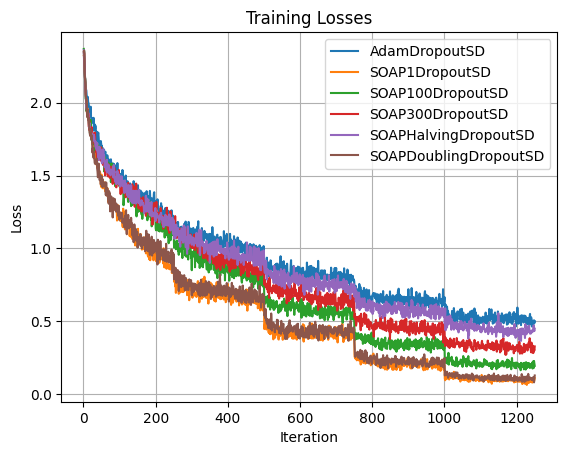

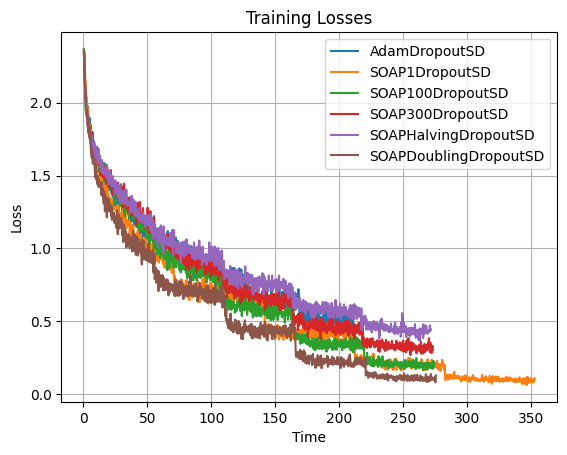

In [ ]:
plt.figure()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.grid(True)

for name, (losses, steps) in stepsLosses:
    plt.plot(steps, losses, label=name)

plt.legend()

plt.figure()
plt.xlabel("Time")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.grid(True)

for name, (losses, times) in timesLosses:
    plt.plot(times, losses, label=name)

plt.legend()
plt.show()

Then, here are the average learning dynamics averaged again by epoch, to get a much clearer plot and comparison of all the algorithms:

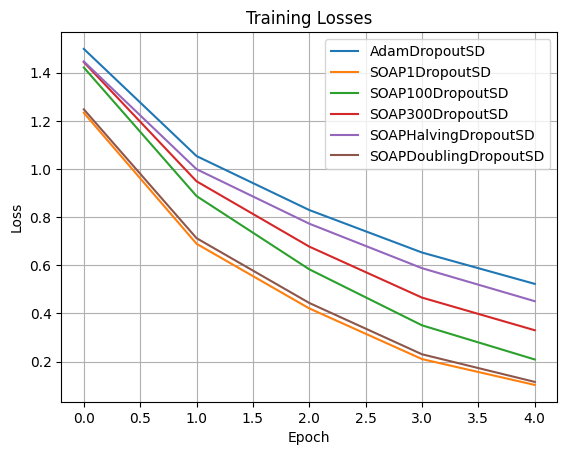

In [ ]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.grid(True)
for name, (losses, steps) in stepsLosses:
  plt.plot([i for i in range(total_epochs)], [sum([losses[i] for i in range(250 * epoch, 250 * (epoch + 1))])/250 for epoch in range(total_epochs)], label=name)

plt.legend()
plt.show()

Also, here are the average learning dynamics sampled every 125 steps to also give a clearer view in time:

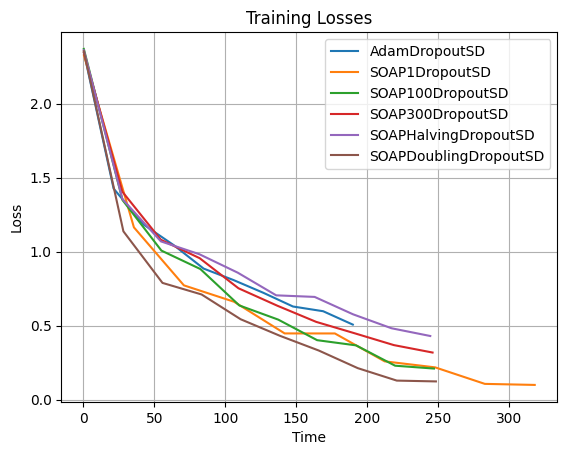

In [ ]:
plt.xlabel("Time")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.grid(True)
for name, (losses, times) in timesLosses:
  plt.plot([times[i] for i in range(len(times)) if i % 125 == 0] , [losses[i] for i in range(len(losses)) if i % 125 == 0], label=name)

plt.legend()
plt.show()

Last but not least, let's measure the test accuracy of the different models we have trained (an average for each optimizer configuration):

In [5]:
!pip install torchmetrics

In [ ]:
import torchmetrics

# Set up of multiclass accuracy metric
acc = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

for name, trainings in models:
    # For each optimizer configuration, compute the average accuracy of the num_trainings instances
    test_accuracy = 0

    for model, optimizer in trainings:
        model.eval()

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                acc(preds, labels)

        test_accuracy += acc.compute()
        acc.reset()

    test_accuracy /= num_trainings
    print(f"{name} - Test accuracy: {test_accuracy}")

AdamDropoutSD - Test accuracy: 0.773080050945282
SOAP1DropoutSD - Test accuracy: 0.855679988861084
SOAP100DropoutSD - Test accuracy: 0.8212399482727051
SOAP300DropoutSD - Test accuracy: 0.811020016670227
SOAPHalvingDropoutSD - Test accuracy: 0.8045200705528259
SOAPDoublingDropoutSD - Test accuracy: 0.8537399172782898
SOAPDoublingThenHalvingDropoutSD - Test accuracy: 0.10052000731229782
SOAPLossChangeDropoutSD - Test accuracy: 0.09894000738859177


It is possible to see that the models' test accuracies reflect the training losses, so that the faster/better convergence caused by different schedules for the frequency of the preconditioner updates is also effective for real-world model performance.

Let's now repeat the training/plot/test process for some other additional schedules:

In [6]:
optimizers_configs = [
    ("AdamDropoutSD", lambda model: torch.optim.Adam(model.parameters(), lr=0.005)),
    #("SOAP1DropoutSD", lambda model: SOAP(model.parameters(), lr=0.005, precondition_frequency=1)),
    ("SOAP10DropoutSD", lambda model: SOAP(model.parameters(), lr=0.005, precondition_frequency=10)),  # it behaves similarly to SOAP1, only in less time
    #("SOAP100DropoutSD", lambda model: SOAP(model.parameters(), lr=0.005, precondition_frequency=100)),
    #("SOAP300DropoutSD", lambda model: SOAP(model.parameters(), lr=0.005, precondition_frequency=300)),
    #("SOAPHalvingDropoutSD", lambda model: SOAP(model.parameters(), lr=0.005, precondition_frequency=1024, precondition_frequency_routine=halving_frequency)),
    #("SOAPDoublingDropoutSD", lambda model: SOAP(model.parameters(), lr=0.005, precondition_frequency=1, precondition_frequency_routine=doubling_frequency)),
    ("SOAPFixedIntervalDropoutSD", lambda model: SOAP(model.parameters(), lr=0.005, precondition_frequency=8, precondition_frequency_routine=fixed_interval_doubling_frequency)),
    ("SOAPLossChangeDropoutSD", lambda model: SOAP(model.parameters(), lr=0.005, precondition_frequency=0.3, precondition_frequency_routine=loss_dependent_frequency)),
    ("SOAPDoublingClipped256DropoutSD", lambda model: SOAP(model.parameters(), lr=0.005, precondition_frequency=1, precondition_frequency_routine=doubling_frequency)),
]

In [7]:
models = []
num_trainings = 5           # Number of identical models to be trained to average the loss function dynamics

for name, optimizer_function in optimizers_configs:
    trainings = []

    for i in range(num_trainings):
        # Instantiate a ResNet18 model and set both dropout rate and stochastic depth to 0.3
        model = timm.create_model('resnet18', pretrained=False, num_classes=10, drop_rate=0.3, drop_path_rate=0.3)

        # Since the ResNet18 takes 224x224 images as inputs, change the input layer in order to avoid useless inputs which would behave like noise
        model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        model.maxpool = nn.Identity()

        model = model.to(device)
        optimizer = optimizer_function(model)

        trainings.append((model, optimizer))

    models.append((name, trainings))

# pairs (losses, avg_steps) or (losses, avg_times) for each type of optimizer
stepsLosses = []
timesLosses = []

# Train all the models
for name, trainings in models:
    losses_per_run = []
    times_per_run = []

    # For each model, train it num_trainings times and compute the average losses and times
    for model, optimizer in trainings:
        steps, losses, times = train_chosen_optimizer(model, optimizer)
        print(f"\nPreconditioner updates = {counter}\n")

        losses_per_run.append(losses)
        times_per_run.append(times)

        # Uncomment if you want to save the model state - you also need to set up the model counter i
        # torch.save(model.state_dict(), f"model_weights_{name}_{i}.pth")

    avg_losses = []
    avg_times = []

    # Average the loss dynamics and times for each of the identical models trained
    for step in range(len(steps)):
        step_losses = [losses[step] for losses in losses_per_run]
        step_times = [times[step] for times in times_per_run]

        avg_losses.append(sum(step_losses) / len(step_losses))
        avg_times.append(sum(step_times) / len(step_times))

    # This saves the data if one wants to use it later for plots
    try:
        np.savez(name + "PlotData.npz", steps=steps, losses=avg_losses, times=avg_times)
    except Exception as e:
        print(f"Error: {name} {e}")

    stepsLosses.append((name, (avg_losses, steps)))
    timesLosses.append((name, (avg_losses, avg_times)))

Epoch: 1/5



100%|██████████| 250/250 [00:41<00:00,  6.04it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:40<00:00,  6.12it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:41<00:00,  6.07it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:40<00:00,  6.11it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:41<00:00,  6.10it/s]



Preconditioner updates = 0

Epoch: 1/5



100%|██████████| 250/250 [00:41<00:00,  6.08it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:41<00:00,  6.08it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:41<00:00,  6.08it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:41<00:00,  6.08it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:41<00:00,  6.09it/s]



Preconditioner updates = 0

Epoch: 1/5



100%|██████████| 250/250 [00:41<00:00,  6.09it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:41<00:00,  6.09it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:41<00:00,  5.99it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:42<00:00,  5.91it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:41<00:00,  6.07it/s]



Preconditioner updates = 0

Epoch: 1/5



100%|██████████| 250/250 [00:41<00:00,  5.97it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:40<00:00,  6.10it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:40<00:00,  6.11it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:40<00:00,  6.10it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:40<00:00,  6.10it/s]



Preconditioner updates = 0

Epoch: 1/5



100%|██████████| 250/250 [00:41<00:00,  6.10it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:40<00:00,  6.11it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:40<00:00,  6.10it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:40<00:00,  6.10it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:40<00:00,  6.10it/s]



Preconditioner updates = 0

Epoch: 1/5



100%|██████████| 250/250 [00:57<00:00,  4.35it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:57<00:00,  4.33it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:57<00:00,  4.35it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:57<00:00,  4.37it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:57<00:00,  4.37it/s]



Preconditioner updates = 7688

Epoch: 1/5



100%|██████████| 250/250 [00:56<00:00,  4.39it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:56<00:00,  4.40it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:56<00:00,  4.39it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:56<00:00,  4.40it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:56<00:00,  4.42it/s]



Preconditioner updates = 7688

Epoch: 1/5



100%|██████████| 250/250 [00:56<00:00,  4.40it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:56<00:00,  4.41it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:57<00:00,  4.37it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:57<00:00,  4.39it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:56<00:00,  4.39it/s]



Preconditioner updates = 7688

Epoch: 1/5



100%|██████████| 250/250 [00:56<00:00,  4.40it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:57<00:00,  4.31it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:58<00:00,  4.30it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:57<00:00,  4.32it/s]



Preconditioner updates = 7688

Epoch: 1/5



100%|██████████| 250/250 [00:57<00:00,  4.36it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:57<00:00,  4.34it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:57<00:00,  4.36it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:56<00:00,  4.39it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:57<00:00,  4.37it/s]



Preconditioner updates = 7688

Epoch: 1/5



100%|██████████| 250/250 [00:58<00:00,  4.30it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:56<00:00,  4.42it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:56<00:00,  4.44it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:55<00:00,  4.49it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:55<00:00,  4.47it/s]



Preconditioner updates = 3783

Epoch: 1/5



100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:56<00:00,  4.42it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:56<00:00,  4.44it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:56<00:00,  4.46it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:55<00:00,  4.47it/s]



Preconditioner updates = 3783

Epoch: 1/5



100%|██████████| 250/250 [00:57<00:00,  4.36it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:56<00:00,  4.44it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:56<00:00,  4.46it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:55<00:00,  4.51it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:55<00:00,  4.51it/s]



Preconditioner updates = 3783

Epoch: 1/5



100%|██████████| 250/250 [00:57<00:00,  4.38it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:56<00:00,  4.45it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:55<00:00,  4.51it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:56<00:00,  4.39it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:56<00:00,  4.42it/s]



Preconditioner updates = 3783

Epoch: 1/5



100%|██████████| 250/250 [00:57<00:00,  4.36it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:56<00:00,  4.45it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:55<00:00,  4.48it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:55<00:00,  4.51it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:55<00:00,  4.50it/s]



Preconditioner updates = 3783

Epoch: 1/5



100%|██████████| 250/250 [01:09<00:00,  3.58it/s]


Epoch: 2/5



100%|██████████| 250/250 [01:10<00:00,  3.56it/s]


Epoch: 3/5



100%|██████████| 250/250 [01:09<00:00,  3.58it/s]


Epoch: 4/5



100%|██████████| 250/250 [01:09<00:00,  3.57it/s]


Epoch: 5/5



100%|██████████| 250/250 [01:09<00:00,  3.60it/s]



Preconditioner updates = 869

Epoch: 1/5



100%|██████████| 250/250 [01:10<00:00,  3.55it/s]


Epoch: 2/5



100%|██████████| 250/250 [01:09<00:00,  3.58it/s]


Epoch: 3/5



100%|██████████| 250/250 [01:09<00:00,  3.59it/s]


Epoch: 4/5



100%|██████████| 250/250 [01:09<00:00,  3.57it/s]


Epoch: 5/5



100%|██████████| 250/250 [01:10<00:00,  3.53it/s]



Preconditioner updates = 807

Epoch: 1/5



100%|██████████| 250/250 [01:14<00:00,  3.38it/s]


Epoch: 2/5



100%|██████████| 250/250 [01:10<00:00,  3.53it/s]


Epoch: 3/5



100%|██████████| 250/250 [01:11<00:00,  3.50it/s]


Epoch: 4/5



100%|██████████| 250/250 [01:09<00:00,  3.59it/s]


Epoch: 5/5



100%|██████████| 250/250 [01:09<00:00,  3.59it/s]



Preconditioner updates = 621

Epoch: 1/5



100%|██████████| 250/250 [01:10<00:00,  3.55it/s]


Epoch: 2/5



100%|██████████| 250/250 [01:09<00:00,  3.58it/s]


Epoch: 3/5



100%|██████████| 250/250 [01:09<00:00,  3.58it/s]


Epoch: 4/5



100%|██████████| 250/250 [01:09<00:00,  3.57it/s]


Epoch: 5/5



100%|██████████| 250/250 [01:10<00:00,  3.55it/s]



Preconditioner updates = 869

Epoch: 1/5



100%|██████████| 250/250 [01:10<00:00,  3.55it/s]


Epoch: 2/5



100%|██████████| 250/250 [01:10<00:00,  3.56it/s]


Epoch: 3/5



100%|██████████| 250/250 [01:10<00:00,  3.56it/s]


Epoch: 4/5



100%|██████████| 250/250 [01:09<00:00,  3.59it/s]


Epoch: 5/5



100%|██████████| 250/250 [01:09<00:00,  3.59it/s]



Preconditioner updates = 683

Epoch: 1/5



100%|██████████| 250/250 [00:56<00:00,  4.45it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:55<00:00,  4.50it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:55<00:00,  4.47it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:55<00:00,  4.52it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:55<00:00,  4.51it/s]



Preconditioner updates = 621

Epoch: 1/5



100%|██████████| 250/250 [00:55<00:00,  4.47it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:55<00:00,  4.50it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:55<00:00,  4.50it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:55<00:00,  4.53it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:55<00:00,  4.51it/s]



Preconditioner updates = 621

Epoch: 1/5



100%|██████████| 250/250 [00:55<00:00,  4.47it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:55<00:00,  4.50it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:55<00:00,  4.51it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:55<00:00,  4.50it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:55<00:00,  4.52it/s]



Preconditioner updates = 621

Epoch: 1/5



100%|██████████| 250/250 [00:56<00:00,  4.45it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:55<00:00,  4.52it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:55<00:00,  4.48it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:55<00:00,  4.51it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:55<00:00,  4.50it/s]



Preconditioner updates = 621

Epoch: 1/5



100%|██████████| 250/250 [00:56<00:00,  4.44it/s]


Epoch: 2/5



100%|██████████| 250/250 [00:55<00:00,  4.51it/s]


Epoch: 3/5



100%|██████████| 250/250 [00:55<00:00,  4.47it/s]


Epoch: 4/5



100%|██████████| 250/250 [00:55<00:00,  4.50it/s]


Epoch: 5/5



100%|██████████| 250/250 [00:55<00:00,  4.49it/s]


Preconditioner updates = 621



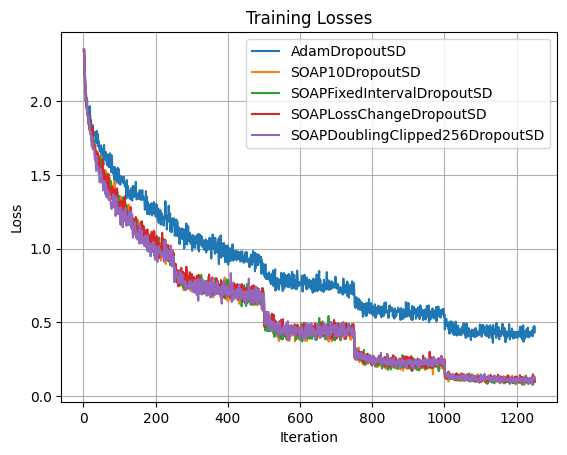

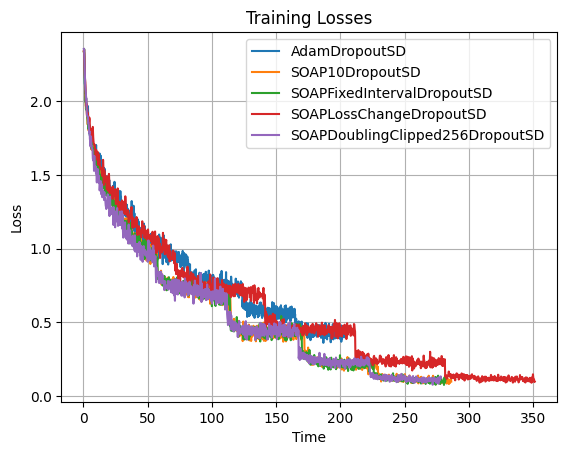

In [12]:
plt.figure()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.grid(True)

for name, (losses, steps) in stepsLosses:
    plt.plot(steps, losses, label=name)

plt.legend()

plt.figure()
plt.xlabel("Time")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.grid(True)

for name, (losses, times) in timesLosses:
    plt.plot(times, losses, label=name)

plt.legend()
plt.show()

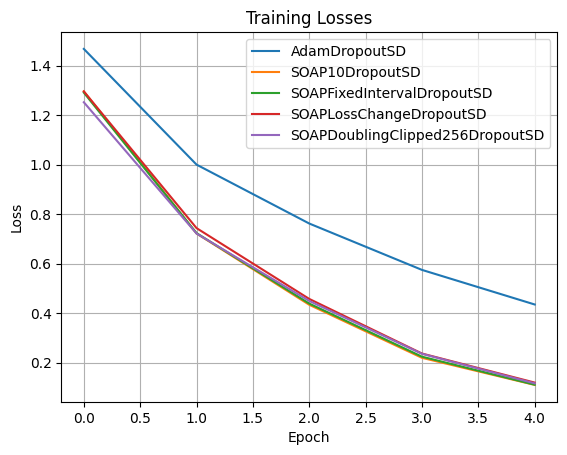

In [19]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.grid(True)
for name, (losses, steps) in stepsLosses:
  plt.plot([i for i in range(total_epochs)], [sum([losses[i] for i in range(250 * epoch, 250 * (epoch + 1))])/250 for epoch in range(total_epochs)], label=name)

plt.legend()
plt.show()

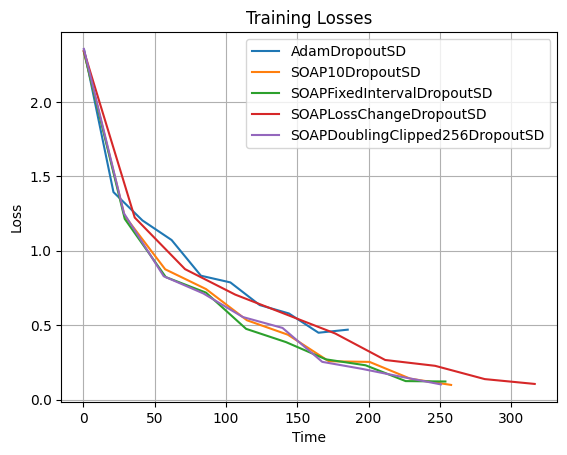

In [20]:
plt.xlabel("Time")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.grid(True)
for name, (losses, times) in timesLosses:
  plt.plot([times[i] for i in range(len(times)) if i % 125 == 0] , [losses[i] for i in range(len(losses)) if i % 125 == 0], label=name)

plt.legend()
plt.show()

In [16]:
import torchmetrics

# Set up of multiclass accuracy metric
acc = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

for name, trainings in models:
    # For each optimizer configuration, compute the average accuracy of the num_trainings instances
    test_accuracy = 0

    for model, optimizer in trainings:
        model.eval()

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                acc(preds, labels)

        test_accuracy += acc.compute()
        acc.reset()

    test_accuracy /= num_trainings
    print(f"{name} - Test accuracy: {test_accuracy}")

AdamDropoutSD - Test accuracy: 0.8102399706840515
SOAP10DropoutSD - Test accuracy: 0.8447400331497192
SOAPFixedIntervalDropoutSD - Test accuracy: 0.8451600074768066
SOAPLossChangeDropoutSD - Test accuracy: 0.8448999524116516
SOAPDoublingClipped256DropoutSD - Test accuracy: 0.8490399718284607
